# NOTEBOOK FOR INFERENCE ON ELECTRO L2 DATA

## IMPORT ALL REQUIRED PACKAGES

In [20]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchmetrics
from PIL import Image
from tqdm import tqdm
import numpy as np
import gc
import os
import warnings
import matplotlib.pyplot as plt
from torch import nn
from IPython.display import clear_output
from torcheval.metrics.functional import multiclass_f1_score
import random
from skimage.transform import resize as interp_resize
import segmentation_models_pytorch as smp
import tifffile as tff
import patoolib
import glob
%matplotlib inline
warnings.filterwarnings("ignore")

In [5]:
np.set_printoptions(threshold=1e7)
# ITS RECOMMENDED TO USE CUDA DEVICE
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
your_current_dir = os.getcwd()
print('Your device :',device)
print('Your current dir of this .ipynb file',your_current_dir)

Your device : cuda
Your current dir of this .ipynb file C:\Users\nikita.belyakov\Documents\GitHub\CLOUD_SNOW_SEGMENTATION\RES_4_KM


## FIX RANDOM SEED EVERYWHERE TO MAKE RESULTS STABLE

In [6]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_everything(seed=42)

## INITIALIZE ALL NEEDED FUNCTIONS FOR POSTPROCESSING PREDICTIONS OF MODEL

In [7]:
def batch_to_img(xb, idx=0):
    img = np.array(xb.squeeze(0))
    return np.array(img.transpose((1,2,0))*255)
def transpose_patch(patch):
    tr = np.array(patch).astype(np.uint8).transpose((2,0,1))
    return tr
def predb_to_mask(predb,idx=0):
    p = torch.functional.F.softmax(predb.squeeze(0), 0)
    return p.argmax(0).cpu()
def inverse_normalize(tensor,mean,std,num_shannels =5):
    tensor = tensor.detach().cpu().numpy()
    # unnormalize the RGB channels
    for i in range(num_shannels):
        tensor[i] = (tensor[i] * std[i]) + mean[i]
    # clip values to [0, 1] range
    tensor = np.clip(tensor, 0, 1)
    # convert back to uint8
    tensor = (tensor * 255).astype(np.uint8)
    return tensor
def open_sample_as_pil_no_norm(datacube):
    inversed_rgb = (datacube[0:3])
    rgb = np.dstack((inversed_rgb[2,:,:],inversed_rgb[1,:,:],inversed_rgb[0,:,:]))*255
    return rgb.astype('uint8')
def open_DEM(datacube):
    dem_arr = datacube[5]#*255
    return dem_arr.numpy()#.astype('uint8')
def open_mask_as_pil(seglabel):
    mask = (seglabel.numpy())
    return mask

## SPLITTING ELECTRO-L № 2 STACK OF RGB and 6 BT CHANNELS TO PATCHES AND SAVE THEM FOR DATASET

In [29]:
def split_LONLATDEM_stack_4km(stack, patch_size,dir_name):
    print('init stack shape =', stack.shape)
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    if stack.shape[0]%patch_size!=0:
        print('cut margins to split 224*224 patches')
        stack = stack[48:-48,48:-48,:]
        print('stack shape =', stack.shape)
    n_patches_h = stack.shape[0] // patch_size
    n_patches_w = stack.shape[1] // patch_size
    print('n_patches_h,n_patches_w',n_patches_h,n_patches_w)
    # Check if the image can be evenly divided into patches
    assert stack.shape[0] == n_patches_h * patch_size, f"Image height {stack.shape} is not divisible by patch height {patch_size}"
    assert stack.shape[1] == n_patches_w * patch_size, f"Image width {stack.shape} is not divisible by patch width {patch_size}"
    # Split the image into non-overlapping patches
    patches,nonempty_idxs = [],[]
    for i in tqdm(range(n_patches_h)):
        for j in range(n_patches_w):
            patch = stack[i * patch_size:(i + 1) * patch_size, j * patch_size:(j + 1) * patch_size]
            patch_name= dir_name+'patch_'+str(n_patches_w*i+j)+'.tif'
            tff.imwrite(patch_name, patch)
    print('############## geoinfo in 4km res successfully splitted! ####################')
    
def split_rgb_L2(year, month, time, date, patch_size = 224):
    default_dir = your_current_dir+'/data_inference/'
    dir_name = default_dir+'all_patch_folder_ZSA/patches_rgb_electro_l2_'+date+'_'+time+'/'
    nonempty_idxs_dir = default_dir+'nonempty_idxs_folder/'
    Met10_dir = default_dir + 'masks_of_Met_10_and_GOES_16_for_L2.tif'
    rgb_dir = default_dir + 'rgb_ZSA_'+time+'.tif'
    rgb_EL2 = tff.imread(rgb_dir)
    r,g,b = rgb_EL2[:,:,0],rgb_EL2[:,:,1],rgb_EL2[:,:,2]
    Met10_disk = tff.imread(Met10_dir)//255
    r = r*Met10_disk
    g = g*Met10_disk
    b = b*Met10_disk
    stack = np.dstack([r,g,b])
    ########################
    print('init stack shape =', stack.shape)
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    if not os.path.exists(nonempty_idxs_dir):
        os.makedirs(nonempty_idxs_dir)
    if stack.shape[0]%patch_size!=0:
    # Calculate the number of patches in each dimension
        stack = stack[48:-48,48:-48,:]
    n_patches_h = stack.shape[0] // patch_size
    n_patches_w = stack.shape[1] // patch_size
    print('n_patches_h,n_patches_w',n_patches_h,n_patches_w)
    # Check if the image can be evenly divided into patches
    assert stack.shape[0] == n_patches_h * patch_size, f"Image height {stack.shape} is not divisible by patch height {patch_size}"
    assert stack.shape[1] == n_patches_w * patch_size, f"Image width {stack.shape} is not divisible by patch width {patch_size}"
    # Split the image into non-overlapping patches
    patches,nonempty_idxs = [],[]
    for i in (range(n_patches_h)):
        for j in range(n_patches_w):
            patch = stack[i * patch_size:(i + 1) * patch_size, j * patch_size:(j + 1) * patch_size]
            b_patch = patch[:,:,0].flatten()
            empty_flag = np.sum(b_patch)
            if empty_flag>1000000:
                nonempty_idxs.append(n_patches_w*i+j)
            patch_name= dir_name+'patch_'+str(n_patches_w*i+j)+'.tif'
            tff.imwrite(patch_name, patch)
    nonempty_idxs_name = nonempty_idxs_dir+'nonempty_idxs_electro_l2_'+date+'_'+time+'.npy'
    np.save(nonempty_idxs_name,np.array(nonempty_idxs))
    print('num of no-empty patches', len(nonempty_idxs))
    print('############## rgb L2 successfully splitted! ####################')
    
def split_BT_stack_L2(year, month, time, date, patch_size = 224):
    default_dir =  your_current_dir+'/data_inference/'
    dir_name = default_dir+'all_patch_folder_BT/patches_BT_electro_l2_'+date+'_'+time+'/'
    Met10_dir = default_dir + 'masks_of_Met_10_and_GOES_16_for_L2.tif'
    BT_dir = default_dir + 'BT_normed_'+time+'.tif'
    BT_EL2 = tff.imread(BT_dir)
    BT4, BT5, BT6, BT7, BT8, BT9 = BT_EL2[:,:,0],BT_EL2[:,:,1],BT_EL2[:,:,2],BT_EL2[:,:,3],BT_EL2[:,:,4],BT_EL2[:,:,5]
    Met10_disk = tff.imread(Met10_dir)//255
    BT4 = BT4*Met10_disk
    BT5 = BT5*Met10_disk
    BT6 = BT6*Met10_disk
    BT7 = BT7*Met10_disk
    BT8 = BT8*Met10_disk
    BT9 = BT9*Met10_disk
    stack = np.dstack([BT4, BT5, BT6, BT7, BT8, BT9])
    print('init stack shape =', stack.shape)
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    if stack.shape[0]%patch_size!=0:
        #print('############full img processing!!!!!!!')
        stack = stack[48:-48,48:-48,:]
    # Calculate the number of patches in each dimension
    n_patches_h = stack.shape[0] // patch_size
    n_patches_w = stack.shape[1] // patch_size
    print('n_patches_h,n_patches_w',n_patches_h,n_patches_w)
    # Check if the image can be evenly divided into patches
    assert stack.shape[0] == n_patches_h * patch_size, f"Image height {stack.shape} is not divisible by patch height {patch_size}"
    assert stack.shape[1] == n_patches_w * patch_size, f"Image width {stack.shape} is not divisible by patch width {patch_size}"
    # Split the image into non-overlapping patches
    for i in (range(n_patches_h)):
        for j in range(n_patches_w):
            patch = stack[i * patch_size:(i + 1) * patch_size, j * patch_size:(j + 1) * patch_size]
            patch_name= dir_name+'patch_'+str(n_patches_w*i+j)+'.tif'
            tff.imwrite(patch_name, patch)
    print('############## BT successfully splitted! ####################')
    
def split_masks_L2(year, month, time, date, patch_size = 224, plot = False):
    default_dir =  your_current_dir+'/data_inference/'
    dir_name = default_dir+'all_masks_folder/patches_masks_electro_l2_'+date+'_'+time+'/'
    snowy_idxs_dir = default_dir+'snowy_idxs_folder/'
    Met10_dir = default_dir + 'masks_of_Met_10_and_GOES_16_for_L2.tif'
    Met10_disk = tff.imread(Met10_dir)//255
    Met10_cloud_mask_dir = default_dir+'both_cloud_mask_'+time+'.tif'
    Met10_cloud_mask = tff.imread(Met10_cloud_mask_dir)
    snow_dir = default_dir + 'snow_map.jpg'
    #################
    snow_map = tff.imread(snow_dir)
    if snow_map.shape[0]!=2784:
        print('res = 2 km, resampling to 4 km res')
        snow_map = np.array(Image.fromarray(snow_map*255).resize((2712,2712),resample=Image.NEAREST))
        snow_map = np.pad(snow_map, (36,36))
        snow_map = (snow_map*255).astype(np.uint8)
    snow_map = snow_map*Met10_disk
    false_snow = (((snow_map/255)*(Met10_cloud_mask/255))*255).astype(np.uint8)
    snow_map_ = snow_map-false_snow
    snow_map_=snow_map_*Met10_disk
    bg = np.zeros((2784,2784)).astype(np.uint8)
    stack = np.dstack([Met10_cloud_mask,snow_map_,bg])
    if plot:
        plt.figure(figsize=(16,16))
        plt.imshow(stack)
        plt.show()
    ####################
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    if not os.path.exists(snowy_idxs_dir):
        os.makedirs(snowy_idxs_dir)
    if stack.shape[0]%patch_size!=0:
        stack = stack[48:-48,48:-48,:]
    n_patches_h = stack.shape[0] // patch_size
    n_patches_w = stack.shape[1] // patch_size
    print('n_patches_h,n_patches_w',n_patches_h,n_patches_w)
    # Check if the image can be evenly divided into patches
    assert stack.shape[0] == n_patches_h * patch_size, f"Image height {stack.shape} is not divisible by patch height {patch_size}"
    assert stack.shape[1] == n_patches_w * patch_size, f"Image width {stack.shape} is not divisible by patch width {patch_size}"
    # Split the image into non-overlapping patches
    snowy_idxs = (np.zeros(144)).astype(np.uint8)
    for i in (range(n_patches_h)):# h = 12
        for j in range(n_patches_w):# w = 12
            patch = stack[i * patch_size:(i + 1) * patch_size, j * patch_size:(j + 1) * patch_size]
            snow_m = patch[:,:,1].copy()
            snow_m[snow_m!=255] = 0
            snow_m[snow_m==255] = 1
            snow_pix = np.sum(snow_m)
            if snow_pix>=400:
                snowy_idxs[n_patches_w*i+j] = 1
            patch_name= dir_name+'patch_'+str(n_patches_w*i+j)+'.jpg'
            tff.imwrite(patch_name,patch.astype(np.uint8))
    snowy_idxs_dirname = snowy_idxs_dir+'snowy_idxs_electro_l2_'+date+'_'+time+'.npy'
    np.save(snowy_idxs_dirname,np.array(snowy_idxs))
    print('num of snowy patches', np.sum(snowy_idxs))
    print('############## Masks successfully splitted! ####################')

### SPLITTING ELECTRO-L № 2 STACK OF GEOINFO (LON, LAT, DEM)

In [45]:
default_dir = your_current_dir+'/data_inference/'
L2_lon_4km = np.load(default_dir + 'lon_4km.npy')
L2_lat_4km = np.load(default_dir + 'lat_4km.npy')
L2_dem_4km = tff.imread(default_dir + 'DEM_from_Met_10.tif')
aux_stack = np.dstack([L2_lon_4km, L2_lat_4km, L2_dem_4km])
lonlatdem_dir = default_dir + 'lon_lat_dem/'
split_LONLATDEM_stack_4km(stack = aux_stack, patch_size = 224, dir_name = lonlatdem_dir)

init stack shape = (2784, 2784, 3)
cut margins to split 224*224 patches
stack shape = (2688, 2688, 3)
n_patches_h,n_patches_w 12 12


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 33.45it/s]

############## geoinfo in 4km res successfully splitted! ####################


### UNRAR BT DATA

In [46]:
#unrar ar archived data
for name in os.listdir(your_current_dir+'/data_inference/'):
    if name.endswith('.rar'):
        try:
            patoolib.extract_archive(your_current_dir+'/data_inference/'+name, outdir=your_current_dir+'/data_inference/')
            clear_output()
        except:
            print('YOU ALREADY UNARCHIVED THIS DATA')

### SPLITTING ELECTRO-L № 2 STACK OF RGB and 6 BT CHANNELS

In [47]:
year = '2023'
times = ['1400']
months = ['january']
dates = ['0115']
for j in tqdm(range(len(months))):
    for time in (times):
        month = months[j]
        date = year+dates[j]
        try:
            split_rgb_L2(year, month, time, date)
            split_BT_stack_L2(year, month, time, date)
            split_masks_L2(year, month, time, date)
        except:
            print('FILE/ timestamp DOES NOT EXIST!---> next')

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

init stack shape = (2784, 2784, 3)
n_patches_h,n_patches_w 12 12
num of no-empty patches 117
############## rgb L2 successfully splitted! ####################
init stack shape = (2784, 2784, 6)
n_patches_h,n_patches_w 12 12
############## BT successfully splitted! ####################
res = 2 km, resampling to 4 km res
n_patches_h,n_patches_w 12 12


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.65s/it]

num of snowy patches 6
############## Masks successfully splitted! ####################


### CHECK THAT ALL IS OK BY VISUALIZING 1 PATCH FROM SPLITTED IMG

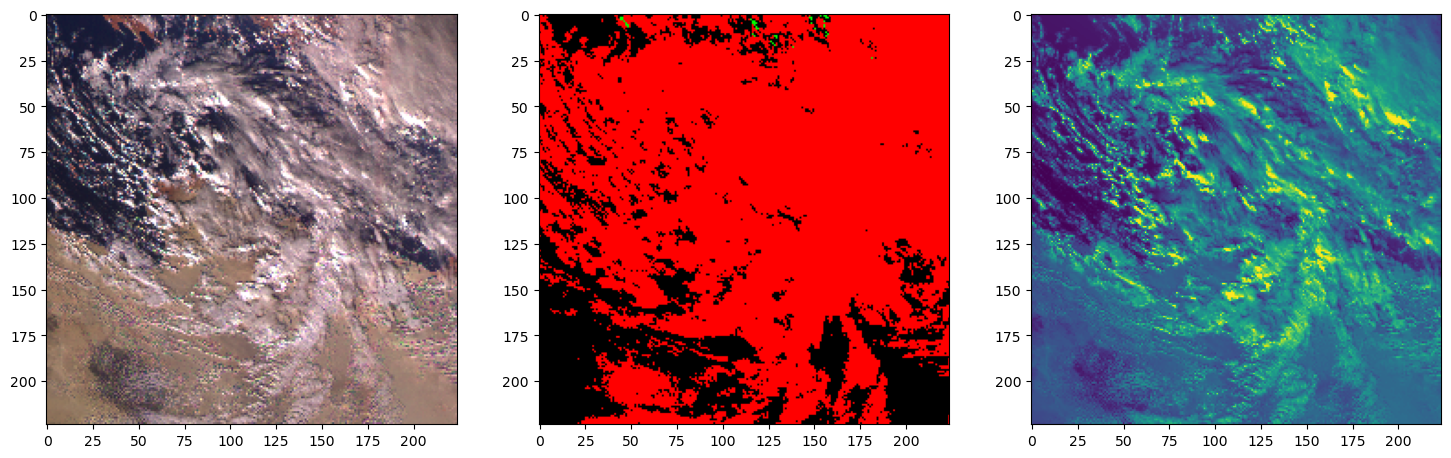

In [48]:
patch_ = tff.imread(default_dir + '/all_patch_folder_ZSA/patches_rgb_electro_l2_20230115_1400/patch_33.tif')
mask_ = tff.imread(default_dir + '/all_masks_folder/patches_masks_electro_l2_20230115_1400/patch_33.jpg')
bgr_ = patch_[:,:,:3].astype(np.uint8)
dem_ = patch_[:,:,-1]
fig, ax = plt.subplots(1,3, figsize=(18,6))
ax[0].imshow(bgr_)
ax[1].imshow(mask_)
ax[2].imshow(dem_)
plt.show()

## ELECTRO-L №2 PATCHES DATASET CLASS

In [33]:
class Electro_L2_Dataset(Dataset):
    def __init__(self, stack_dir_list, aux_dir, pytorch=True, include_BT = True):
        super().__init__()
        self.pytorch = pytorch   
        self.include_BT = include_BT
        self.stack_dir_list = stack_dir_list
        self.aux_dir = aux_dir
        self.stack_dirs = []
        self.stack_dirs_BT = []
        total_len = 0
        for i in range(len(self.stack_dir_list)): # iterate over number of pictures in dataset
            stack_dir = self.stack_dir_list[i]
            stack_dir_BT = self.stack_dir_list[i].replace('rgb', 'BT').replace('folder_ZSA','folder_BT')
            patch_files = glob.glob(stack_dir+'/*')
            patch_files_BT = glob.glob(stack_dir_BT+'/*')
            for j in range(len(patch_files)):
                patch_file = stack_dir+'/patch_'+str(j)+'.tif'
                self.stack_dirs.append(patch_file)
                patch_file_BT = patch_file.replace('rgb', 'BT').replace('folder_ZSA','folder_BT')
                self.stack_dirs_BT.append(patch_file_BT)        
    def __len__(self):
        num_patches = int((len(self.stack_dirs))) 
        return num_patches
    
    def open_rgb_normed(self, idx, invert=False):
        patch_file = self.stack_dirs[idx]
        patch = tff.imread(patch_file)
        r,g,b = patch[:,:,0]/255, patch[:,:,1]/255, patch[:,:,2]/255
        patch_normed  = np.dstack([b, g ,r])
        return patch_normed 
    
    def open_BT_normed(self, idx, invert=False):
        patch_file_BT = self.stack_dirs_BT[idx]
        patch_BT = tff.imread(patch_file_BT)
        return patch_BT 
    
    def open_aux(self, idx, invert=False):
        patch_file = self.aux_dir+'/patch_'+str(idx)+'.tif'
        patch = tff.imread(patch_file)
        lon,lat,dem = patch[:,:,0],patch[:,:,1],patch[:,:,2]
        lon,lat = (lon+180.0)/360.0,(lat+90.0)/180.0
        dem = dem/10000
        lonlatdem_normed = np.dstack([lon,lat,dem])
        return lonlatdem_normed
    
    def open_as_pil(self, idx):
        patch_file = self.stack_dirs[idx]
        patch_image = tff.imread(patch_file)
        return patch_image 
    
    def open_mask(self, idx):
        patch_file = self.stack_dirs[idx]
        mask_file = patch_file.replace('rgb','masks').replace('tif','jpg').replace('all_patch_folder_ZSA','all_masks_folder')
        mask = tff.imread(mask_file)
        snow_mask = mask[:,:,1]//255 #  1 - snow class
        cloud_mask = mask[:,:,0] # 2 - cloud class
        cloud_mask[cloud_mask!=0] = 255
        bg = mask[:,:,2]
        bin_mask = snow_mask + cloud_mask
        return mask#bin_mask
    
    def __getitem__(self, idx):
        patch_file = self.stack_dirs[idx]
        patch = tff.imread(patch_file)
        mask_file = patch_file.replace('rgb','masks').replace('tif','jpg').replace('all_patch_folder_ZSA','all_masks_folder')
        mask = tff.imread(mask_file)
        snow_mask = mask[:,:,1]//255 #  1 - snow class
        cloud_mask = mask[:,:,0] # 2 - cloud class
        cloud_mask[cloud_mask!=0]=2
        bin_mask = snow_mask+cloud_mask
        r,g,b = patch[:,:,0]/255, patch[:,:,1]/255, patch[:,:,2]/255
        aux_file = self.aux_dir+'/patch_'+str(idx)+'.tif'
        aux = tff.imread(aux_file)
        lon,lat,dem = aux[:,:,0],aux[:,:,1],aux[:,:,2]
        lon,lat = (lon+180.0)/360.0,(lat+90.0)/180.0
        dem = dem/10000
        aux_normed = np.stack([lon, lat, dem])
        patch_normed  = np.stack([b, g ,r])
        if self.include_BT:
            patch_file_BT = self.stack_dirs_BT[idx] 
            BT_normed = tff.imread(patch_file_BT).transpose(2,0,1)
            full_stack = np.concatenate((patch_normed, BT_normed, aux_normed), axis=0)
            # order of channels: b, g, r, BT4, BT5, BT6, BT7, BT8, BT9, lon, lat, dem
            full_stack = torch.tensor(full_stack, dtype=torch.float32)
        else:
            full_stack = np.concatenate((patch_normed, aux_normed), axis=0)
            full_stack = torch.tensor(full_stack, dtype=torch.float32)
        return full_stack,bin_mask

### Initialize Electro_L2_Dataset

input channels ranges:
tensor(0.1255) tensor(0.9294)
tensor(0.0588) tensor(1.)
tensor(0.0392) tensor(1.)
tensor(0.6280) tensor(0.8640)
tensor(0.4040) tensor(0.6782)
tensor(0.6924) tensor(0.8748)
tensor(0.7036) tensor(0.8894)
tensor(0.7027) tensor(0.8933)
tensor(0.8042) tensor(0.9405)
tensor(0.5126) tensor(0.5555)
tensor(0.6439) tensor(0.7055)
tensor(0.) tensor(0.1988)


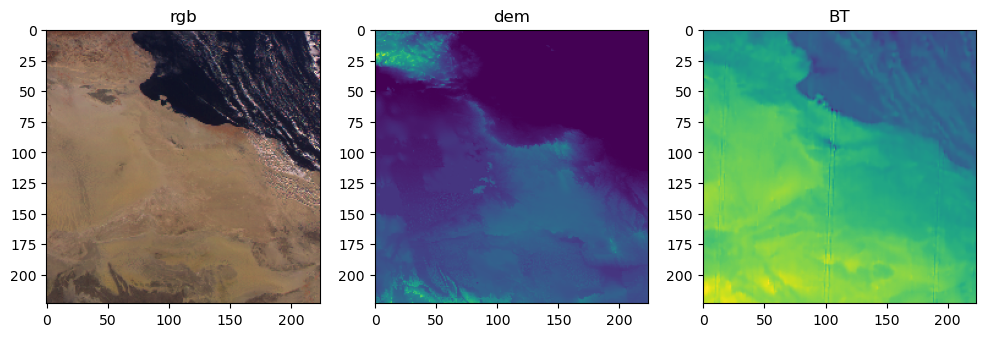

(torch.Size([12, 224, 224]), 144)

In [34]:
year = '2023'
time = '1400'
month = 'january'
date = '20230115'
stack_dir = [default_dir + '/all_patch_folder_ZSA/patches_rgb_electro_l2_'+date+'_'+time]
aux_dir_l2 = default_dir + '/lon_lat_dem'
Electro_L2_ds = Electro_L2_Dataset(stack_dir_list=stack_dir, aux_dir = aux_dir_l2, include_BT = True)
SAMPLE_INDX =32
x_rgb_lonlat, y = Electro_L2_ds[SAMPLE_INDX]
print('input channels ranges:')
for i in range(len(x_rgb_lonlat)):
    print(torch.min(x_rgb_lonlat[i]),torch.max(x_rgb_lonlat[i]))
fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].imshow(Electro_L2_ds.open_as_pil(SAMPLE_INDX))
ax[1].imshow(Electro_L2_ds.open_aux(SAMPLE_INDX)[:,:,-1])
ax[2].imshow(Electro_L2_ds.open_BT_normed(SAMPLE_INDX)[:,:,0])
ax[0].set_title('rgb')
ax[1].set_title('dem')
ax[2].set_title('BT')
plt.show()
x_rgb_lonlat.shape ,len(Electro_L2_ds)

## MODEL INITIALIZATION

In [37]:
# lets initialize  architecture of segmentation FOR ALL 12 channels
model = smp.MAnet(
    encoder_name='efficientnet-b0', 
    in_channels=12,
    classes=3,)

### EVAL PREDICTIONS OF THE FULL IMG PATCH BY PATCH

In [39]:
device = 'cuda'
model_path = your_current_dir+'/models/MAnet_Efficient_b0_12_inputs_4km_res_ep_216'
model.load_state_dict(torch.load(model_path))
model.eval()
def pred_and_save_masks(idx, model,dataset,pred_dir_cloud):
    model.cuda()
    try:x_rgb_lonlat, y = dataset[idx]
    except:print('cant open sample number:',idx)
    x_rgb_lonlat = x_rgb_lonlat.to(device)
    cloud_mask = model(x_rgb_lonlat.unsqueeze(0))
    pred=predb_to_mask(cloud_mask).numpy()
    cloud_mask,snow_mask = pred.copy(),pred.copy()
    cloud_mask[cloud_mask!=2] = 0 
    cloud_mask[cloud_mask==2] = 255
    snow_mask[snow_mask!=1] = 0 
    snow_mask[snow_mask==1] = 255
    pred_dir_snow = pred_dir_cloud.replace('cloud', 'snow')
    pred_name_cloud = pred_dir_cloud + 'patch_'+str(idx)+'.jpg'
    pred_name_snow = pred_dir_snow + 'patch_'+str(idx)+'.jpg'
    if not os.path.exists(pred_dir_cloud):
        os.makedirs(pred_dir_cloud)
    if not os.path.exists(pred_dir_snow):
        os.makedirs(pred_dir_snow)
    tff.imsave(pred_name_cloud,cloud_mask.astype(np.uint8))
    tff.imsave(pred_name_snow,snow_mask.astype(np.uint8))
pred_dir_cloud = default_dir+'/predicts/'+date+'_'+time+'/predict_cloud_MAnet/'
for idx in tqdm(range(len(Electro_L2_ds))):
    pred_and_save_masks(idx=idx, model = model, dataset = Electro_L2_ds,pred_dir_cloud = pred_dir_cloud)

100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:12<00:00, 11.89it/s]


### MERGE PATCHES OF MASKS TO THE FULL EARTH DISK MASK

100%|██████████████████████████████████████████████████████████████████████████████| 144/144 [00:00<00:00, 1233.95it/s]


(2784, 2784)


100%|██████████████████████████████████████████████████████████████████████████████| 144/144 [00:00<00:00, 1173.82it/s]


(2784, 2784)


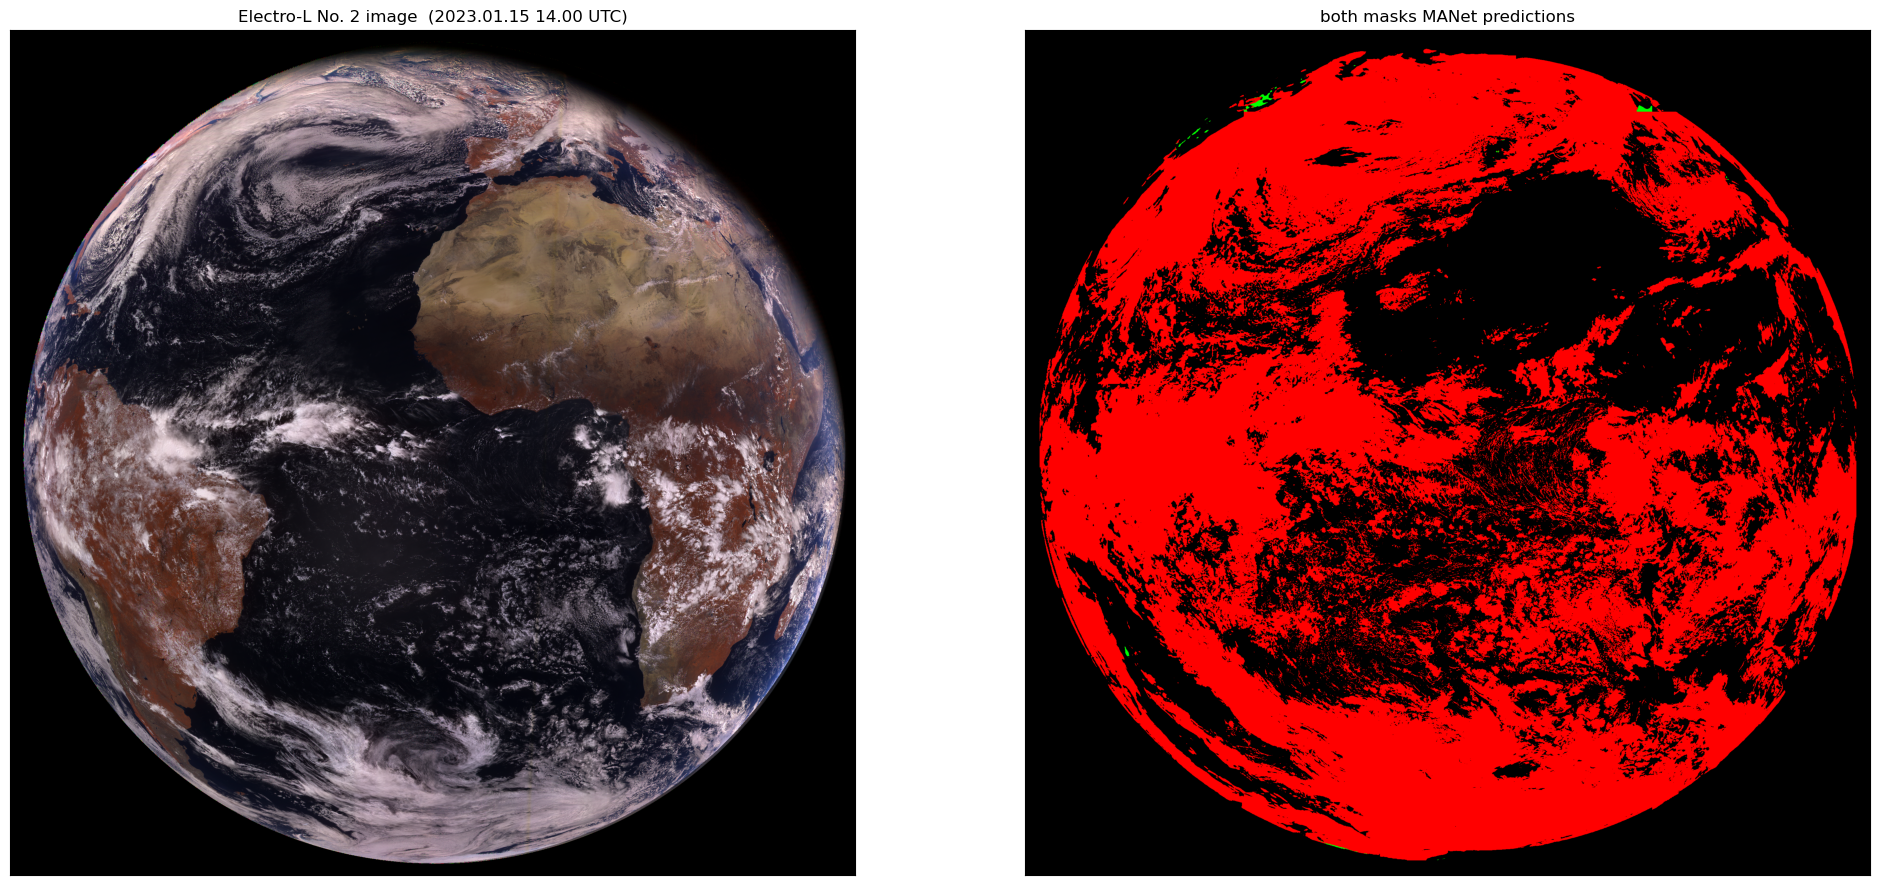

In [41]:
def merge_masks_cloud(pred_dir, time, date,output_shape = (2688, 2688)):
    mask_folder_cloud = pred_dir+date+'_'+time+'/predict_cloud_MAnet'
    merged_mask_file_name_cloud = mask_folder_cloud + '.jpg'
    output_matrix = np.zeros(output_shape, dtype=np.uint8)
    # Loop through each patch and insert it into the output matrix
    for i in tqdm(range(144)):
        patch_file = f"{mask_folder_cloud}/patch_{i}.jpg"
        patch_image = tff.imread(patch_file)
        row = (i // 12) * 224
        col = (i % 12) * 224
        output_matrix[row:row+224, col:col+224] = patch_image
    output_matrix = np.pad(output_matrix,((48,48),(48,48)))
    print(output_matrix.shape)
    # Save the output matrix to the specified file
    tff.imsave(merged_mask_file_name_cloud, output_matrix)
    return output_matrix
def merge_masks_snow(pred_dir, time, date,output_shape = (2688, 2688)):
    mask_folder_snow = pred_dir+date+'_'+time+'/predict_snow_MAnet'
    merged_mask_file_name_snow = mask_folder_snow + '.jpg'
    output_matrix = np.zeros(output_shape, dtype=np.uint8)
    # Loop through each patch and insert it into the output matrix
    for i in tqdm(range(144)):
        patch_file = f"{mask_folder_snow}/patch_{i}.jpg"
        patch_image = tff.imread(patch_file)
        row = (i // 12) * 224
        col = (i % 12) * 224
        output_matrix[row:row+224, col:col+224] = patch_image
    output_matrix = np.pad(output_matrix,((48,48),(48,48)))
    print(output_matrix.shape)
    # Save the output matrix to the specified file
    tff.imsave(merged_mask_file_name_snow, output_matrix)
    return output_matrix
def make_composed_masks(merged_mask_cloud,merged_mask_snow,default_dir,pred_dir,year, month, time, date, plot = True):
    rgb_nir = tff.imread(default_dir+'/rgb_ZSA_'+time+'.tif')
    composed_cloud = np.dstack((rgb_nir[:,:,0],rgb_nir[:,:,1],merged_mask_cloud))
    composed_snow = np.dstack((rgb_nir[:,:,0],rgb_nir[:,:,1],merged_mask_snow))
    composed_both_masks = np.dstack((merged_mask_snow,rgb_nir[:,:,0],merged_mask_cloud))
    composed_masks_dir = pred_dir+date+'_'+time+'/composed_masks_MAnet.jpg'
    composed_snow_dir = pred_dir+date+'_'+time+'/composed_with_snow_MAnet.jpg'
    composed_cloud_dir = pred_dir+date+'_'+time+'/composed_with_cloud_MAnet.jpg'
    Image.fromarray(composed_snow.astype(np.uint8)).save(composed_snow_dir)
    Image.fromarray(composed_cloud.astype(np.uint8)).save(composed_cloud_dir)
    Image.fromarray(composed_both_masks.astype(np.uint8)).save(composed_masks_dir)
    if plot:
        fig, ax = plt.subplots(1,2, figsize=(24,12))
        ax[0].imshow(rgb_nir)
        bg = np.zeros((2784, 2784), dtype=np.uint8)
        ax[1].imshow(np.dstack((merged_mask_cloud,merged_mask_snow,bg)))
        ax[1].set_title('both masks MANet predictions')
        date_lab = date[:4]+'.'+date[4:-2]+'.'+date[-2:]
        time_lab = time[:2]+'.'+time[-2:]
        time_label = ' ('+date_lab+' '+time_lab+ ' UTC)'
        label = 'Electro-L No. 2 image '+time_label
        ax[0].set_title(label)
        ax[0].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
        ax[1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
        plt.show()
    #return merged_mask_cloud, merged_mask_snow
pred_dir = default_dir+'/predicts/'
merged_mask_cloud = merge_masks_cloud(pred_dir, time, date)
merged_mask_snow = merge_masks_snow(pred_dir, time, date)
make_composed_masks(merged_mask_cloud,merged_mask_snow,default_dir,pred_dir,year, month, time, date)

### COMPUTE METRICS FOR THE FULL IMG MANet PREDICTION

F1 and IoU results of Electro-L No. 2 MAnet tested on Met-10 masks
Test F1 score: 0.8147, Test IoU: 0.7655
Test FAR: 0.0826
Test F1 score for each class (bg, cloud, snow): tensor([0.9193, 0.8869, 0.6379]), 
Test IoU for each class (bg, cloud, snow): tensor([0.8543, 0.8107, 0.6315])


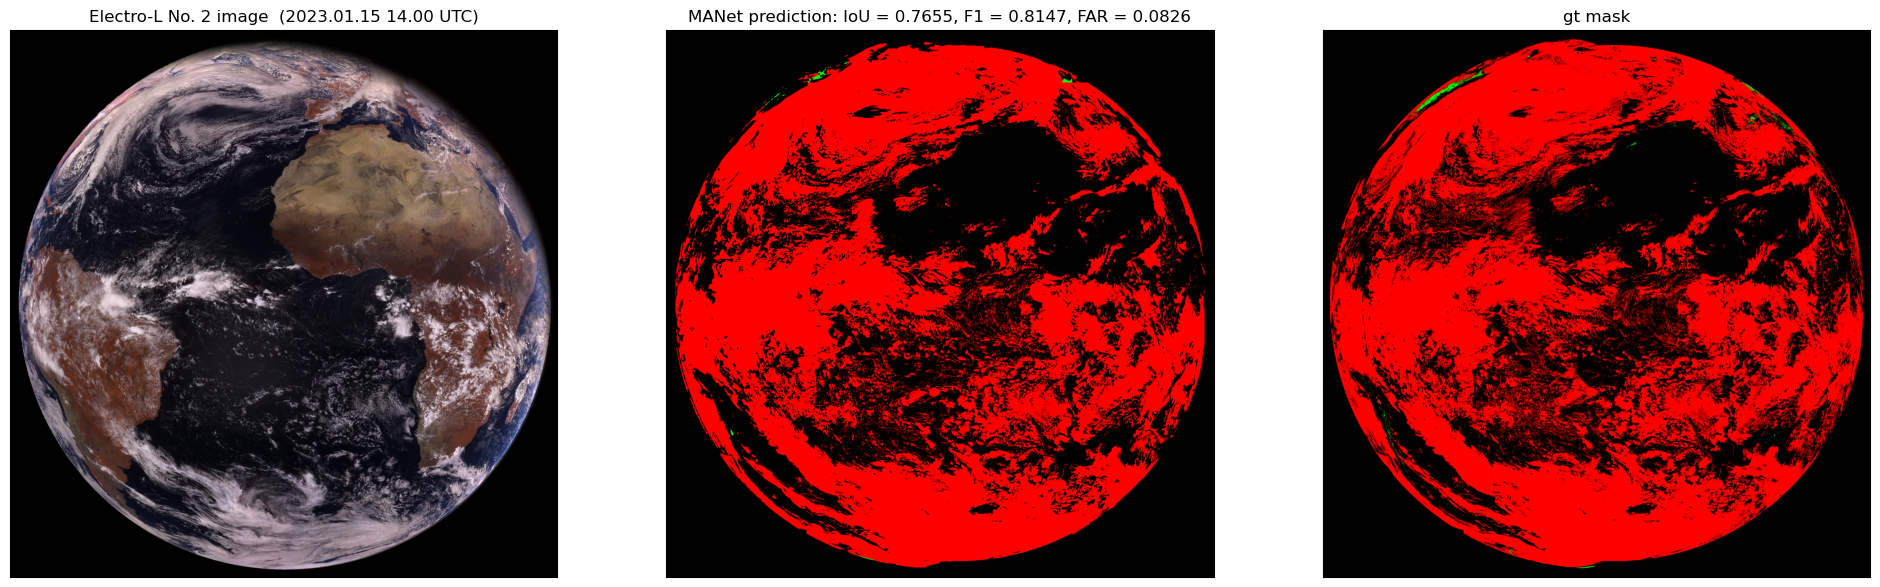

In [43]:
def compute_metrics_full_img_L2(merged_mask_snow,merged_mask_cloud, default_dir,pred_dir,year, month, time, date, plot = True):
    merged_pred_snow = merged_mask_snow.copy()
    merged_pred_cloud = merged_mask_cloud.copy()
    merged_pred_snow[merged_pred_snow!=0] = 255
    merged_pred_cloud[merged_pred_cloud!=0] = 255
    merged_mask_snow[merged_mask_snow!=0] = 2
    merged_mask_cloud[merged_mask_cloud!=0] = 1
    try:
        cloud_mask = tff.imread(default_dir+'/both_cloud_mask_'+time+'.tif')
        Met10_dir = default_dir + 'masks_of_Met_10_and_GOES_16_for_L2.tif'
        Met10_disk = tff.imread(Met10_dir)//255
    except:
        cloud_mask = tff.imread(default_dir+year+'/'+month+'_15/cloud_'+time+'_Met_10_reproj.jpg')
        Met10_dir = default_dir + 'Met_10_reproj.jpg'
        Met10_disk = np.array(Image.open(Met10_dir)).mean(axis = 2).astype(int)
        Met10_disk[Met10_disk<255]=0
        Met10_disk=(Met10_disk//255).astype(np.uint8)
    snow_map = tff.imread(default_dir+'snow_map.jpg')
    if snow_map.shape[0]!=2784:
            snow_map = np.array(Image.fromarray(snow_map*255).resize((2712,2712),resample=Image.NEAREST))
            snow_map = np.pad(snow_map, (36,36))
            snow_map = (snow_map*255).astype(np.uint8)
    false_snow = ((snow_map/255)*(cloud_mask/255)*255).astype(np.uint8)
    true_snow_mask = snow_map-false_snow
    true_snow_mask[true_snow_mask!=0] = 2
    cloud_mask[cloud_mask!=0] = 1
    gt_mask = cloud_mask+true_snow_mask
    gt_mask = Met10_disk*gt_mask
#     test_f1_score = torchmetrics.F1Score(num_classes=3, task = 'multiclass', average = 'macro')
#     test_iou_score = torchmetrics.JaccardIndex(num_classes=3, task = 'multiclass')
#     test_f1_score_sep = torchmetrics.F1Score(num_classes=3, task = 'multiclass', average = None)
#     test_iou_score_sep = torchmetrics.JaccardIndex(num_classes=3, task = 'multiclass', average = None)
    test_acc = torchmetrics.Accuracy(num_classes=3, task = 'multiclass')
    #######################################
    pred_stack_ = merged_mask_snow + merged_mask_cloud
    predictions = torch.tensor(pred_stack_)
    y = torch.tensor(gt_mask)
    tp, fp, fn, tn = smp.metrics.get_stats(predictions, y, num_classes =3, mode='multiclass')
    iou_score_sep = smp.metrics.iou_score(tp, fp, fn, tn, reduction=None)
    f1_score_sep = smp.metrics.f1_score(tp, fp, fn, tn, reduction=None)
    iou_score_sep = torch.sum(iou_score_sep, dim=0)/2784
    f1_score_sep = torch.sum(f1_score_sep, dim=0)/2784
#     print(f1_score_sep)
    iou_score = torch.mean(iou_score_sep).numpy()
    f1_score = torch.mean(f1_score_sep).numpy()
    iou_score = np.round(iou_score,4)
    f1_score = np.round(f1_score,4)
#     test_f1_score.update(predictions, y)
#     test_iou_score.update(predictions, y)
#     test_f1_score_sep.update(predictions, y)
#     test_iou_score_sep.update(predictions, y)
    test_acc.update(predictions, y)
    ############################
#     test_f1 = test_f1_score.compute()
#     test_iou = test_iou_score.compute()
    test_acc = test_acc.compute()
    #calculate the same metrics seperately for each class
#     test_f1_sep = test_f1_score_sep.compute()
#     test_iou_sep = test_iou_score_sep.compute()
    FAR = np.round((1 - test_acc).numpy(),4)
    # printing the results
    print('F1 and IoU results of Electro-L No. 2 MAnet tested on Met-10 masks')
    print(f"Test F1 score: {f1_score:.4f}, Test IoU: {iou_score:.4f}")
    print(f"Test FAR: {FAR:.4f}")
    print(f"Test F1 score for each class (bg, cloud, snow): {f1_score_sep}, \nTest IoU for each class (bg, cloud, snow): {iou_score_sep}")
    if plot:
        gt_snow, gt_cloud, gt_bg = (true_snow_mask/2*255).astype(np.uint8),(cloud_mask*255).astype(np.uint8), np.zeros((2784,2784)).astype(np.uint8)
        gt_snow = gt_snow*Met10_disk
        gt_cloud = gt_cloud*Met10_disk
        gt_stack = np.dstack([gt_cloud, gt_snow,gt_bg])
        pred_stack = np.dstack([merged_pred_cloud,merged_pred_snow,gt_bg])
        rgb_nir = tff.imread(default_dir+'/rgb_ZSA_'+time+'.tif')
        fig, ax = plt.subplots(1,3, figsize=(24,12))
        ax[-1].imshow(gt_stack)
        plt.tick_params(left = False, right = False , labelleft = False ,
                        labelbottom = False, bottom = False)
        ax[-1].set_title('gt mask')
        ax[1].imshow(pred_stack)
        ax[1].set_title('MANet prediction: IoU = '+str(iou_score)+', F1 = '+str(f1_score)+', FAR = '+str(FAR))
        ax[0].imshow(rgb_nir)
        date_lab = date[:4]+'.'+date[4:-2]+'.'+date[-2:]
        time_lab = time[:2]+'.'+time[-2:]
        time_label = ' ('+date_lab+' '+time_lab+ ' UTC)'
        label = 'Electro-L No. 2 image '+time_label
        ax[0].set_title(label)
        # hide ticks on plots
        ax[0].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
        ax[1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
        ax[2].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
        plt.show()
compute_metrics_full_img_L2(merged_mask_snow, merged_mask_cloud, default_dir, pred_dir, year, month, time, date)